<a href="https://colab.research.google.com/github/vjuge/oc-iml/blob/P6/modules/P6/module_P6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P6


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageShow
import cv2 as cv

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.models import load_model
from tensorflow.keras import layers

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



2022-06-08 11:46:48.847002: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 11:46:48.847031: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else: print('Found GPU at: {}'.format(device_name))

GPU device not found


2022-06-08 11:46:50.483201: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-08 11:46:50.484864: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vincent/devel/vjuge/oc-iml/venv/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-08 11:46:50.484877: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-08 11:46:50.484891: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rocketstation): /proc/driver/nvidia/version does not exist


In [3]:

def load_dataset(display_summary=False, as_supervised=True) -> tuple[tf.data.Dataset, tf.data.Dataset, tfds.core.DatasetInfo] :
    """Return Train, Test datasets and related informations
    :return: 
    ds_train (tf.data.DataSet) The requested training dataset.
    ds_test (tf.data.DataSet) The requested test dataset.
    ds_info (tfds.core.DatasetInfo) The requested dataset info.
    """
    # https://www.tensorflow.org/datasets/catalog/stanford_dogs
    (ds_train, ds_test), ds_info = tfds.load('stanford_dogs', 
                                                split=['train', 'test'], 
                                                shuffle_files=True, 
                                                as_supervised=as_supervised,
                                                with_info=True)
    assert isinstance(ds_train, tf.data.Dataset)
    if (display_summary): print(ds_info)
    return ds_train, ds_test, ds_info


ds_train, ds_test, ds_info = load_dataset(display_summary=True, as_supervised=True)

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='~/tensorflow_datasets/stanford_dogs/0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
           

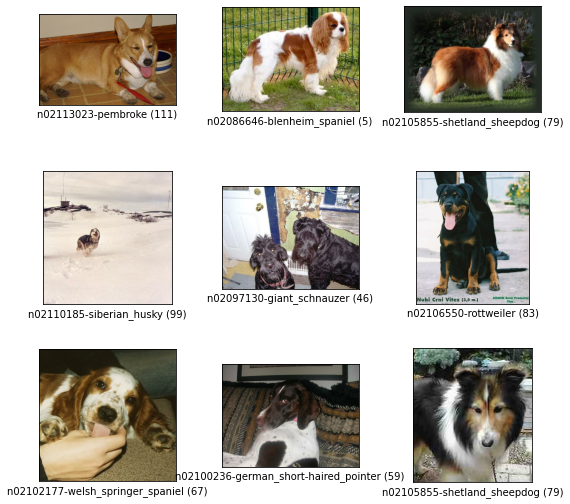

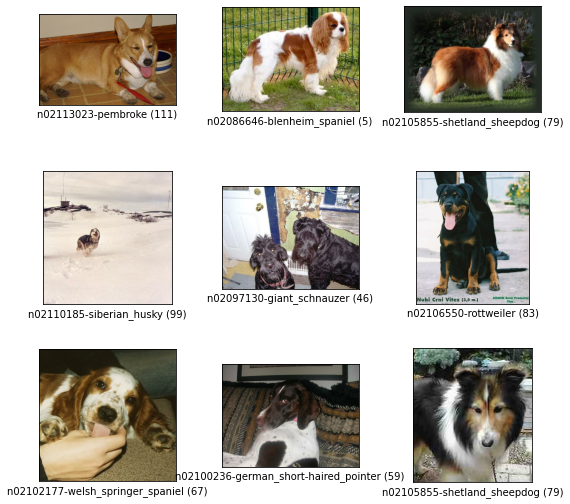

In [4]:
# show examples of samples from dataset

tfds.show_examples(ds_train, ds_info)
# for image, label in tfds.as_numpy(ds_train.take(1)):
#   print(type(image), image.shape, type(label), label)
#   Image.fromarray(image).show()


In [5]:
ds_info.features
ds_info.splits
ds_info.splits['train'].filenames

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

{'train': <SplitInfo num_examples=12000, num_shards=4>,
 'test': <SplitInfo num_examples=8580, num_shards=4>}

['stanford_dogs-train.tfrecord-00000-of-00004',
 'stanford_dogs-train.tfrecord-00001-of-00004',
 'stanford_dogs-train.tfrecord-00002-of-00004',
 'stanford_dogs-train.tfrecord-00003-of-00004']

In [6]:
num_classes = ds_info.features['label'].num_classes
print(num_classes)

120


tf.Tensor(63, shape=(), dtype=int64)


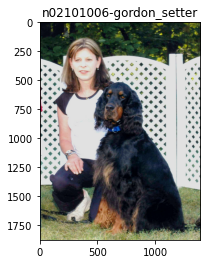

In [7]:
get_label_name = ds_info.features['label'].int2str

image, label = next(iter(ds_train))
print(label)
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Preprocessing

Here we want to preprocess images: resizing, scaling, augment data, etc.


### Resizing & Scaling

In [8]:
IMG_SIZE = 244

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

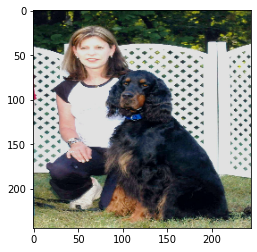

In [9]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [10]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 0.951178


### Data Augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [12]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

<Figure size 720x720 with 0 Axes>

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

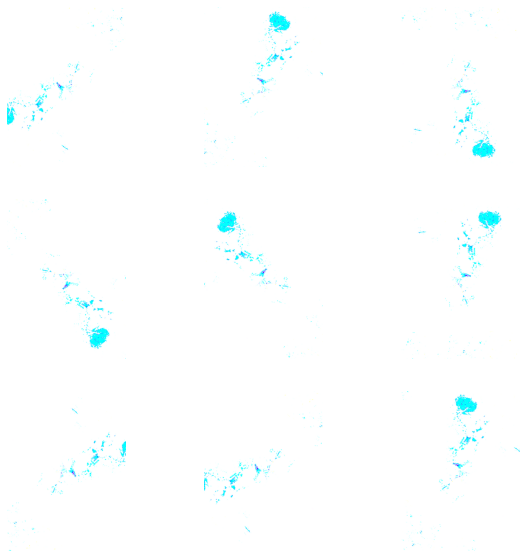

In [13]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [27]:

for images, labels in ds_train.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

labels = []

for x, y in ds_train:
    labels.append(y.numpy())
    # print(y.numpy())

np.max(labels)
np.min(labels)


119

0

(array([1200., 1200., 1200., 1200., 1200., 1200., 1200., 1200., 1200.,
        1200.]),
 array([  0. ,  11.9,  23.8,  35.7,  47.6,  59.5,  71.4,  83.3,  95.2,
        107.1, 119. ]),
 <BarContainer object of 10 artists>)

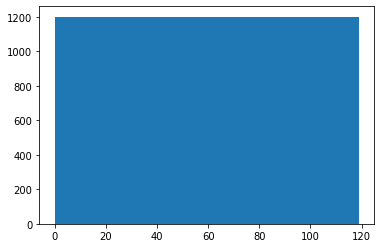

In [36]:
plt.hist(labels[:])

## Dummy model

In [5]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

def resize_img(data, dimensions= (224, 224)):
    print(type(data))
    # return cv.resize(data['image'], dimensions, interpolation=cv.INTER_LINEAR)
    return tf.image.resize(data['image'], dimensions, method='nearest')

In [6]:
ds_train, ds_test, ds_info = load_dataset(as_supervised=False)

In [114]:
ds_train = ds_train.map(lambda data: resize_img(data))
ds_test = ds_test.map(lambda data: resize_img(data))

<class 'dict'>
<class 'dict'>


In [7]:
# ds_train = ds_train.map(
#     normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)




In [8]:
# ds_test = ds_test.map(
#     normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


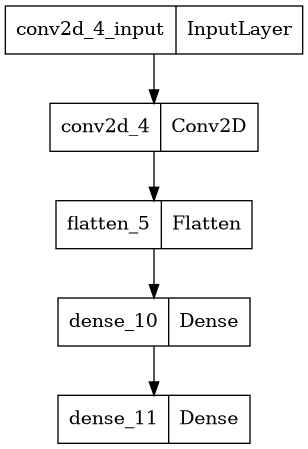

In [22]:

model = Sequential([
    Conv2D(filters=16,
            kernel_size=(3,3), 
            padding='same',
            use_bias=False,
            input_shape=(224,224,3)),
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(210)
])

plot_model(model)


In [24]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


In [25]:
train_data_gen = ImageDataGenerator(
    rescale=1./255
)

test_data_gen = ImageDataGenerator(
    rescale=1./255
)

In [26]:

model.fit(
    ds_train,
    epochs=6,
    validation_data=test_data_gen.flow(
        ds_test)
        
)


TypeError: float() argument must be a string or a number, not 'PrefetchDataset'

In [8]:
import matplotlib.pyplot as plt
from PIL import Image, ImageShow


for image, label in tfds.as_numpy(ds.take(3)):
  # print(type(image), type(label), label)
  # print(image)
  img = tf.keras.preprocessing.image.array_to_img(image)
  display(img)

ImportError: Could not import PIL.Image. The use of `array_to_img` requires PIL.

## Appendix

In [ ]:
# !pip install mlflow --quiet
# !pip install pyngrok --quiet
# !databricks configure --host https://community.cloud.databricks.com/vincentjuge@gmau


In [ ]:
# import mlflow
# mlflow.set_tracking_uri("databricks")
# mlflow.set_experiment("module_P6")

In [ ]:
# from pyngrok import conf, ngrok

# conf.get_default().auth_token = "29zP9P1odMu9Cc6uXkJiPLIHv5H_3EGpswe7jL1Ey6HZwyFs7"

# Open a HTTP tunnel on the default port 80
# <NgrokTunnel: "http://<public_sub>.ngrok.io" -> "http://localhost:80">

# http_tunnel = ngrok.connect()

# Open a SSH tunnel
# <NgrokTunnel: "tcp://0.tcp.ngrok.io:12345" -> "localhost:22">

# ssh_tunnel = ngrok.connect(22, "tcp")